In [1]:
from qce import *

from time import time


from scipy.stats import unitary_group, gaussian_kde

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)

In [2]:
def aux_info(dms, labels, n_layers, pars, n_copies=1, n_meas=0):

    n_inp = int(log2(len(dms[0])))
    n_tot = n_inp*n_copies
    d = 2**n_tot
    d_diff = 2**(n_tot - n_meas)
    
    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    
    ansatz = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    # CX_cascade = cx_cascade(n_tot)
    # ansatz = hea_cx_rzrx(n_tot, n_layers, CX_cascade, pars_ans)

    obs_u = ansatz.conj().T@kron_A_N(diag(pars_est), d_diff)@ansatz
    obs_u_sq = obs_u@obs_u
    
    # projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    # projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]

    dms_cop = [reduce(kron, [dm]*n_copies) for dm in dms]
    
    expecs = []
    disps = []
    # for j in range(len(labels)): # take a density matrix from the training set
    #     print(j, end="\r")
    #     probs = [trace(dms_cop[j]@proj).real for proj in projs_u]
    #     expec = sum([ev*prob for ev, prob in zip(pars_est, probs)])
    #     disp = sum([ev**2*prob for ev, prob in zip(pars_est, probs)]) - expec**2
    #     expecs.append(expec)
    #     disps.append(disp)
    for dm in dms_cop:
        expec = trace(dm@obs_u).real
        disp = trace(dm@obs_u_sq).real - expec**2
        expecs.append(expec)
        disps.append(disp)
        
    
    return array(expecs), array(disps)

### Settings

In [4]:
n_inp = 2
n_train = 1000
n_test = 10000
mixed = True
marks = "neg"

dms_train, labels_train_lin = gen_even_ent_data(n_train, n_inp=n_inp, mixed=mixed, marks=marks)
dms_test, labels_test_lin = gen_even_ent_data(n_test, n_inp=n_inp, mixed=mixed, marks=marks)
purities_test = [trace(dm@dm).real for dm in dms_test]

w_ls = 1e0
w_var = 1e-4
method = "BFGS"
options = {"maxiter": int(1e3)}#, "maxfun": int(1e10)}#

In [5]:
path = r"/home/kardashin/Work/QPE/Results/Entanglement/Squared negativity/"
info = "T=%d-w_ls=%f-w_var=%f-marks=%s-mixed=%s" %(n_train, w_ls, w_var, marks, mixed)

In [6]:
labels_train = array(labels_train_lin)**2
labels_test = array(labels_test_lin)**2

In [7]:
np.save(path + info + "-labels_train_lin", labels_train_lin)
np.save(path + info + "-dms_train", dms_train)

#### 1 copy start

In [7]:
n_copies_1 = 1
n_meas_1 = n_inp*n_copies_1
n_tot_1 = n_inp*n_copies_1
n_layers_1 = 2

x0 = concatenate([normal(pi/2, 0.1, (3*n_tot_1 - 1)*n_layers_1 + 2*n_tot_1), normal(0, 1e-2, 2**n_meas_1)])
# x0 = concatenate([uniform(0, 2*pi, (3*n_tot - 1)*n_layers + 2*n_tot), uniform(-1, 1, 2**n_meas)])
# x0 = array(pars)

file_name = path + "c=%d-m=%d=l=%d-" %(n_copies_1, n_meas_1, n_layers_1) + info + "-pars"

time_start_1 = time()
fvals_1, result_1 = train(dms_train, labels_train, n_layers_1, method=method, 
                          n_copies=n_copies_1, n_meas=n_meas_1, w_ls=w_ls, w_var=w_var, 
                          options=options, x0=x0, save_data=True, file_name=file_name)
time_finish_1 = time() - time_start_1
print("\n\nFinished in", time_finish_1)
print("Cost:", result_1.fun)
print(result_1.message)
pars_1 = result_1.x

Iteration: 76 | Function value: 87.23914620

Finished in 15.037480115890503
Cost: 87.23914619953143
Optimization terminated successfully.


In [8]:
expecs_train_1, disps_train_1 = aux_info(dms_train, labels_train, n_layers_1, pars_1, n_copies=n_copies_1, n_meas=n_meas_1)
expecs_test_1, disps_test_1 = aux_info(dms_test, labels_test, n_layers_1, pars_1, n_copies=n_copies_1, n_meas=n_meas_1)

n_inp: 2 | n_copies: 1 | n_meas: 2 | n_layers: 2 
w_ls: 1.000000 | w_var: 0.000100 

Error: 0.090719017111506


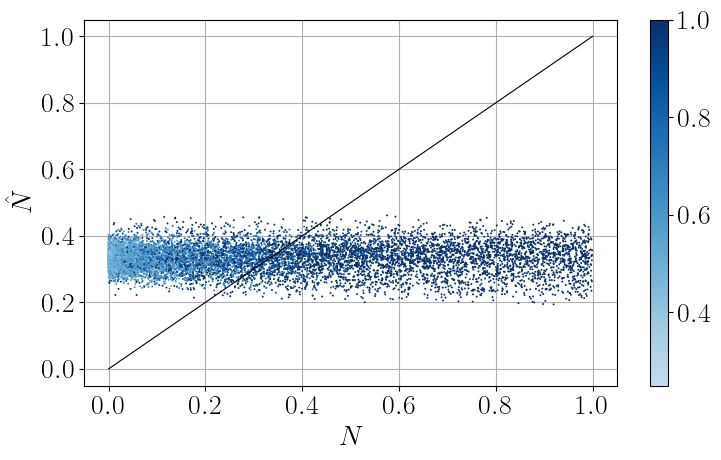

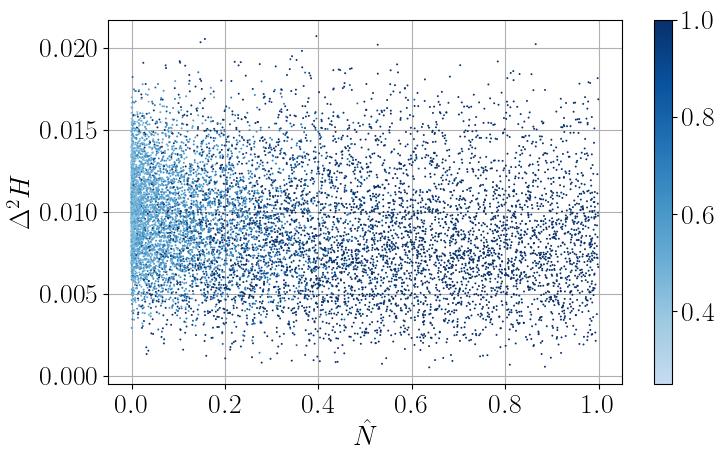

In [9]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies_1, n_meas_1, n_layers_1))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))


cmap_name = "Blues"
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0.25, 1., cmap.N))
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

sum_err_test_1 = sum(np.abs(labels_test - expecs_test_1)**2)/n_test
print("\nError:", sum_err_test_1)

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_1, c=purities_test, cmap=cmap, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N$")
plt.ylabel(r"$\hat{N}$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-pred-test-fin.pdf", bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, disps_test_1, c=purities_test, cmap=cmap, s=2, edgecolor='none')
plt.xlabel(r"$\hat{N}$")
plt.ylabel(r"$\Delta^2 H$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-var-test-fin.pdf", bbox_inches='tight')
plt.show()

#### 2 copies continue

In [10]:
n_copies_2 = 2
n_layers_2 = 2
n_tot_2 = n_inp*n_copies_2
n_meas_2 = n_inp*n_copies_2

# x0_2 = prev_to_next_ansatz(pars_1, n_tot_1, n_meas_1, n_layers_1, n_tot_2, n_meas_2, n_layers_2, subsval=0)
x0_2 = concatenate([normal(pi/2, 0.1, (3*n_tot_2 - 1)*n_layers_2 + 2*n_tot_2), normal(0, 1e-2, 2**n_meas_2)])

file_name = path + "c=%d-m=%d=l=%d-" %(n_copies_2, n_meas_2, n_layers_2) + info + "-pars"

In [11]:
time_start_2 = time()
fvals_2, result_2 = train(dms_train, labels_train, n_layers_2, 
                          n_copies=n_copies_2, n_meas=n_meas_2, x0=x0_2,
                          method=method, w_ls=w_ls, w_var=w_var, options=options, save_data=True, file_name=file_name)
time_finish_2 = time() - time_start_2
print("\n\nFinished in", time_finish_2)
print("Cost:", result_2.fun)
print(result_2.message)
pars_2 = result_2.x

Iteration: 416 | Function value: 1.93408144

Finished in 252.31227254867554
Cost: 1.934081441788205
Optimization terminated successfully.


In [12]:
expecs_train_2, disps_train_2 = aux_info(dms_train, labels_train, n_layers_2, pars_2, n_copies=n_copies_2, n_meas=n_meas_2)
expecs_test_2, disps_test_2 = aux_info(dms_test, labels_test, n_layers_2, pars_2, n_copies=n_copies_2, n_meas=n_meas_2)

n_inp: 2 | n_copies: 2 | n_meas: 4 | n_layers: 2 
w_ls: 1.000000 | w_var: 0.000100 

Error: 0.0018621303462000916


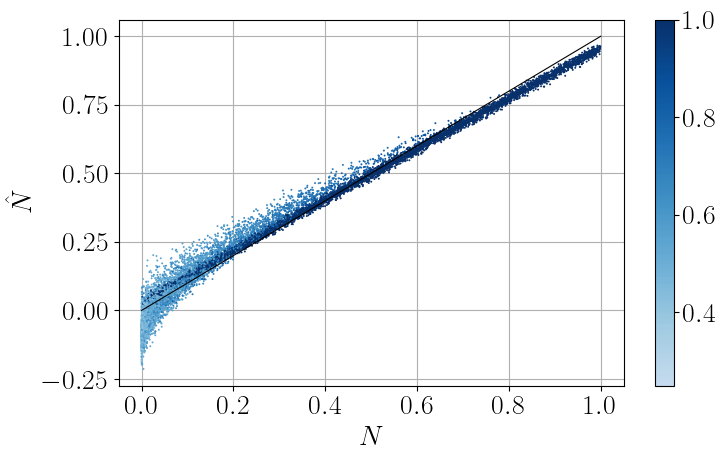

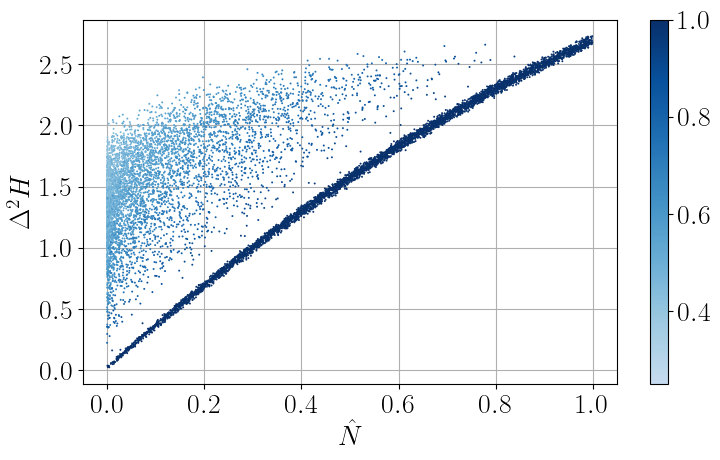

In [13]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies_2, n_meas_2, n_layers_2))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

cmap_name = "Blues"
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0.25, 1., cmap.N))
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

sum_err_test_2 = sum(np.abs(labels_test - expecs_test_2)**2)/n_test
print("\nError:", sum_err_test_2)

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_2, c=purities_test, cmap=cmap, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N$")
plt.ylabel(r"$\hat{N}$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-pred-test-fin.pdf", bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, disps_test_2, c=purities_test, cmap=cmap, s=2, edgecolor='none')
plt.xlabel(r"$\hat{N}$")
plt.ylabel(r"$\Delta^2 H$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-var-test-fin.pdf", bbox_inches='tight')
plt.show()

#### 3 copies continue

In [14]:
n_copies_3 = 3
n_layers_3 = 2
n_tot_3 = n_inp*n_copies_3
n_meas_3 = n_inp*n_copies_3

x0_3 = prev_to_next_ansatz(pars_2, n_tot_2, n_meas_2, n_layers_2, n_tot_3, n_meas_3, n_layers_3, subsval=0)

file_name = path + "c=%d-m=%d=l=%d-" %(n_copies_3, n_meas_3, n_layers_3) + info + "-pars"

In [15]:
time_start_3 = time()
fvals_3, result_3 = train(dms_train, labels_train, n_layers_3, 
                                n_copies=n_copies_3, n_meas=n_meas_3, x0=x0_3,
                                method=method, w_ls=w_ls, w_var=w_var, options=options, save_data=True, file_name=file_name)
time_finish_3 = time() - time_start_3
print("\n\nFinished in", time_finish_3)
print("Cost:", result_3.fun)
print(result_3.message)
pars_3 = result_3.x

Iteration: 239 | Function value: 1.66005884

Finished in 1170.085658788681
Cost: 1.660058836267121
Optimization terminated successfully.


In [16]:
expecs_train_3, disps_train_3 = aux_info(dms_train, labels_train, n_layers_3, pars_3, n_copies=n_copies_3, n_meas=n_meas_3)
expecs_test_3, disps_test_3 = aux_info(dms_test, labels_test, n_layers_3, pars_3, n_copies=n_copies_3, n_meas=n_meas_3)

n_inp: 2 | n_copies: 3 | n_meas: 6 | n_layers: 2 
w_ls: 1.000000 | w_var: 0.000100 

Error: 0.0019420519161576053


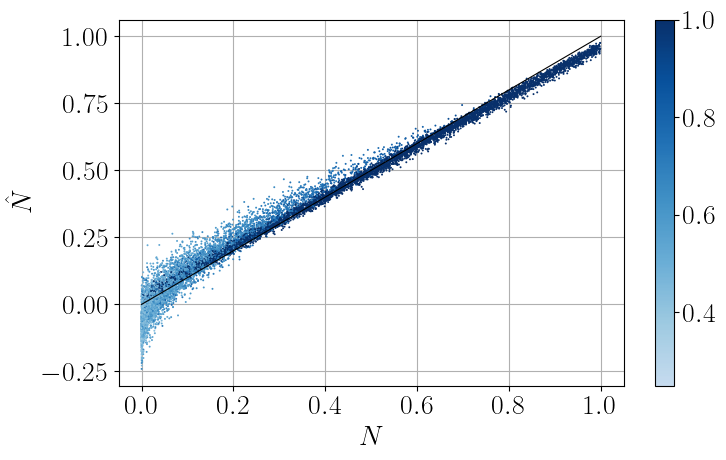

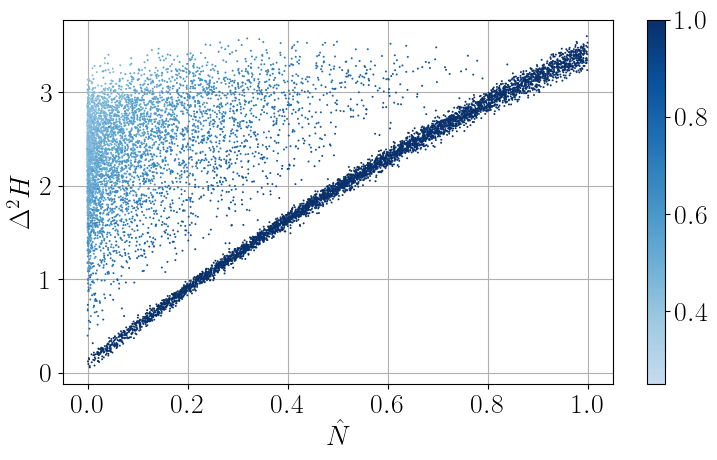

In [17]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies_3, n_meas_3, n_layers_3))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

cmap_name = "Blues"
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0.25, 1., cmap.N))
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

sum_err_test_3 = sum(np.abs(labels_test - expecs_test_3)**2)/n_test
print("\nError:", sum_err_test_3)

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_3, c=purities_test, cmap=cmap, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N$")
plt.ylabel(r"$\hat{N}$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-pred-test-fin.pdf", bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, disps_test_3, c=purities_test, cmap=cmap, s=2, edgecolor='none')
plt.xlabel(r"$\hat{N}$")
plt.ylabel(r"$\Delta^2 H$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-var-test-fin.pdf", bbox_inches='tight')
plt.show()

#### 4 copies continue

In [5]:
n_copies_4 = 4
n_layers_4 = 2
n_tot_4 = n_inp*n_copies_4
n_meas_4 = n_inp*n_copies_4

# x0_4 = prev_to_next_ansatz(pars_3, n_tot_3, n_meas_3, n_layers_3, n_tot_4, n_meas_4, n_layers_4, subsval=0)

file_name = path + "c=%d-m=%d=l=%d-" %(n_copies_4, n_meas_4, n_layers_4) + info + "-pars"

In [19]:
path + pf_4 + "-pars.npy"

'/home/kardashin/Work/Quantum channel estimation/Results/Entanglement/Squared negativity/c=4-m=8=l=2-T=1000-w_ls=1.000000-w_var=0.000100-marks=neg-mixed=True-pars.npy'

In [6]:
# n_inp = 2
# n_train = 1000
# n_test = 10000
# mixed = True
# marks = "neg"

# n_copies_4 = 4
# n_layers_4 = 2
# n_tot_4 = n_inp*n_copies_4
# n_meas_4 = n_inp*n_copies_4


# w_ls = 1e0
# w_var = 1e-4
# method = "BFGS"
# options = {"maxiter": int(1e3)}#, "maxfun": int(1e10)}#

# path = r"/home/kardashin/Work/Quantum channel estimation/Results/Entanglement/Squared negativity/"
# info = "T=%d-w_ls=%f-w_var=%f-marks=%s-mixed=%s" %(n_train, w_ls, w_var, marks, mixed)

# dms_train = np.load(path + info + "-dms_train.npy", allow_pickle=True)
# labels_train_lin = np.load(path + info + "-labels_train_lin.npy", allow_pickle=True)
# dms_test, labels_test_lin = gen_even_ent_data(n_test, n_inp=n_inp, mixed=mixed, marks=marks)
# purities_test = [trace(dm@dm).real for dm in dms_test]

# labels_train = array(labels_train_lin)**2
# labels_test = array(labels_test_lin)**2

# pf_4 = "c=%d-m=%d=l=%d-T=%d-w_ls=%f-w_var=%f-marks=%s-mixed=%s-pars" %(n_copies_4, n_meas_4, n_layers_4, len(labels_train), w_ls, w_var, marks, mixed)
# x0_4 = np.load(path + pf_4 + ".npy", allow_pickle=True)

In [1]:
time_start_4 = time()
fvals_4, result_4 = train(dms_train, labels_train, n_layers_4, 
                                n_copies=n_copies_4, n_meas=n_meas_4, x0=x0_4,
                                method=method, w_ls=w_ls, w_var=w_var, options=options, save_data=True, file_name=file_name)
time_finish_4 = time() - time_start_4
print("\n\nFinished in", time_finish_4)
print("Cost:", result_4.fun)
print(result_4.message)
pars_4 = result_4.x

In [ ]:
expecs_train_4, disps_train_4 = aux_info(dms_train, labels_train, n_layers_4, pars_4, n_copies=n_copies_4, n_meas=n_meas_4)
expecs_test_4, disps_test_4 = aux_info(dms_test, labels_test, n_layers_4, pars_4, n_copies=n_copies_4, n_meas=n_meas_4)

In [ ]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies_4, n_meas_4, n_layers_4))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

cmap_name = "Blues"
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0.25, 1., cmap.N))
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

sum_err_test_4 = sum(np.abs(labels_test - expecs_test_4)**2)/n_test
print("\nError:", sum_err_test_4)

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_4, c=purities_test, cmap=cmap, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N$")
plt.ylabel(r"$\hat{N}$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-pred-test-fin.pdf", bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, disps_test_4, c=purities_test, cmap=cmap, s=2, edgecolor='none')
plt.xlabel(r"$\hat{N}$")
plt.ylabel(r"$\Delta^2 H$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-var-test-fin.pdf", bbox_inches='tight')
plt.show()